In [ ]:
Modelling and Evaluation

# Setup and Loading Data

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from tqdm import tqdm_notebook
import datetime
import lightgbm as lgb # Previously used as a model
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pickle

In [ ]:
df = pd.read_csv('../Data/intermediate/df_w_static.csv', parse_dates=['Date'])
df.head()

,Date,City,Median_PM25,Lat,Long,Country,avg_vis_5000_mean,cf_cvg_5000_mean,avg_vis_5000_min,cf_cvg_5000_min,avg_vis_5000_max,cf_cvg_5000_max,pop_density2010_5000_mean,pop_density2010_5000_min,pop_density2010_5000_max
0,2015-12-03,Jeonju,72.0,35.824272,127.148066,South Korea,288.510375,34.289825,29.397768,20,422.942047,70,2791.798338,2557.745117,3746.27002
1,2015-03-13,Jeonju,144.0,35.824272,127.148066,South Korea,288.510375,34.289825,29.397768,20,422.942047,70,2791.798338,2557.745117,3746.27002
2,2015-05-04,Jeonju,59.0,35.824272,127.148066,South Korea,288.510375,34.289825,29.397768,20,422.942047,70,2791.798338,2557.745117,3746.27002
3,2015-04-21,Jeonju,65.0,35.824272,127.148066,South Korea,288.510375,34.289825,29.397768,20,422.942047,70,2791.798338,2557.745117,3746.27002
4,2015-05-31,Jeonju,142.0,35.824272,127.148066,South Korea,288.510375,34.289825,29.397768,20,422.942047,70,2791.798338,2557.745117,3746.27002


In [ ]:
s5_data = pd.read_csv('../Data/intermediate/timeseries.csv', parse_dates=['Date'])
s5_data.head()

,Date,City,Lat,Long,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,...,4_cloud_optical_depth,4_cloud_top_height,4_cloud_top_pressure,4_surface_albedo,5_absorbing_aerosol_index,5_sensor_altitude,5_sensor_azimuth_angle,5_sensor_zenith_angle,5_solar_azimuth_angle,5_solar_zenith_angle
0,2019-01-01,Abidjan,5.320357,-4.016107,42.386395,80.000000,0.018230,27.433191,1.581902,1.657090,...,7.022340,5520.216125,51727.984926,0.263068,0.426532,829006.890726,71.199255,58.490456,-158.995358,30.440732
1,2019-01-01,Abu Dhabi,24.453835,54.377401,23.007726,59.836009,0.010487,23.244091,-3.186343,-0.870399,...,11.987382,699.836673,93964.168822,0.149670,0.147940,829544.062500,-100.875652,18.235574,-156.023050,51.384541
2,2019-01-01,Accra,5.560014,-0.205744,47.586395,75.800003,0.017800,27.943170,1.521902,1.137090,...,6.687839,3563.538887,66223.286975,0.247198,0.351532,829069.442809,73.198403,42.390270,-153.297991,32.196526
3,2019-01-01,Adapazarı,40.784799,30.399683,6.086396,72.245679,0.002802,0.383724,-0.509019,1.829587,...,4.161432,306.514009,98038.736729,0.128325,-0.910631,832033.829912,-95.234864,45.653226,-157.312289,67.276024
4,2019-01-01,Addis Ababa,9.010793,38.761253,7.786396,67.200005,0.006980,10.633173,-0.978098,-0.962910,...,4.864156,2447.393381,74947.184056,0.203094,-0.397807,829010.437500,-96.951410,53.861768,-139.207225,42.714858


In [ ]:
df.shape, s5_data.shape # Check shapes

((554213, 15), (321345, 37))

In [ ]:
# Remove older readings to keep within the date range covered in the timeseries
df = df.loc[df.Date > s5_data.Date.min()]
df.shape

(268486, 15)

In [ ]:
# Merging the two dataframes
data = pd.merge(s5_data, df, how='left', on=['Date','City', 'Lat', 'Long'])
print(data.shape)
data.head()

(328167, 48)


,Date,City,Lat,Long,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,...,Country,avg_vis_5000_mean,cf_cvg_5000_mean,avg_vis_5000_min,cf_cvg_5000_min,avg_vis_5000_max,cf_cvg_5000_max,pop_density2010_5000_mean,pop_density2010_5000_min,pop_density2010_5000_max
0,2019-01-01,Abidjan,5.320357,-4.016107,42.386395,80.000000,0.018230,27.433191,1.581902,1.657090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,Abu Dhabi,24.453835,54.377401,23.007726,59.836009,0.010487,23.244091,-3.186343,-0.870399,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,Accra,5.560014,-0.205744,47.586395,75.800003,0.017800,27.943170,1.521902,1.137090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,Adapazarı,40.784799,30.399683,6.086396,72.245679,0.002802,0.383724,-0.509019,1.829587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,Addis Ababa,9.010793,38.761253,7.786396,67.200005,0.006980,10.633173,-0.978098,-0.962910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drop some useless columns
to_drop = ['cf_cvg_5000_mean', 'cf_cvg_5000_min', 'cf_cvg_5000_max',# Quality bands, safe to ignore
           'Country', # Not needed
          '0_tropospheric_NO2_column_number_density'] # Too much missing data
data = data.drop(to_drop, axis=1)
data.head()

,Date,City,Lat,Long,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,...,5_sensor_zenith_angle,5_solar_azimuth_angle,5_solar_zenith_angle,Median_PM25,avg_vis_5000_mean,avg_vis_5000_min,avg_vis_5000_max,pop_density2010_5000_mean,pop_density2010_5000_min,pop_density2010_5000_max
0,2019-01-01,Abidjan,5.320357,-4.016107,42.386395,80.000000,0.018230,27.433191,1.581902,1.657090,...,58.490456,-158.995358,30.440732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,Abu Dhabi,24.453835,54.377401,23.007726,59.836009,0.010487,23.244091,-3.186343,-0.870399,...,18.235574,-156.023050,51.384541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,Accra,5.560014,-0.205744,47.586395,75.800003,0.017800,27.943170,1.521902,1.137090,...,42.390270,-153.297991,32.196526,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,Adapazarı,40.784799,30.399683,6.086396,72.245679,0.002802,0.383724,-0.509019,1.829587,...,45.653226,-157.312289,67.276024,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,Addis Ababa,9.010793,38.761253,7.786396,67.200005,0.006980,10.633173,-0.978098,-0.962910,...,53.861768,-139.207225,42.714858,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Fill missing values for columns with only a few missing bits
# We use the mean FOR THAT LOCATION
missing = data.isna().sum().sort_values() # Missing values
few_missing = missing[missing<15000] # Those with <15k missing values
few_missing = few_missing[few_missing>0]
grouped_and_filled = data.groupby('City').transform(lambda x: x.fillna(x.mean()).values)
for col in tqdm(few_missing.index):
    data[col] = grouped_and_filled[col]
data.head()

100%|██████████| 26/26 [00:00<00:00, 1172.48it/s]


,Date,City,Lat,Long,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,...,5_sensor_zenith_angle,5_solar_azimuth_angle,5_solar_zenith_angle,Median_PM25,avg_vis_5000_mean,avg_vis_5000_min,avg_vis_5000_max,pop_density2010_5000_mean,pop_density2010_5000_min,pop_density2010_5000_max
0,2019-01-01,Abidjan,5.320357,-4.016107,42.386395,80.000000,0.018230,27.433191,1.581902,1.657090,...,58.490456,-158.995358,30.440732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,Abu Dhabi,24.453835,54.377401,23.007726,59.836009,0.010487,23.244091,-3.186343,-0.870399,...,18.235574,-156.023050,51.384541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,Accra,5.560014,-0.205744,47.586395,75.800003,0.017800,27.943170,1.521902,1.137090,...,42.390270,-153.297991,32.196526,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,Adapazarı,40.784799,30.399683,6.086396,72.245679,0.002802,0.383724,-0.509019,1.829587,...,45.653226,-157.312289,67.276024,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,Addis Ababa,9.010793,38.761253,7.786396,67.200005,0.006980,10.633173,-0.978098,-0.962910,...,53.861768,-139.207225,42.714858,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.head()

,Date,City,Lat,Long,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,...,5_sensor_zenith_angle,5_solar_azimuth_angle,5_solar_zenith_angle,Median_PM25,avg_vis_5000_mean,avg_vis_5000_min,avg_vis_5000_max,pop_density2010_5000_mean,pop_density2010_5000_min,pop_density2010_5000_max
0,2019-01-01,Abidjan,5.320357,-4.016107,42.386395,80.000000,0.018230,27.433191,1.581902,1.657090,...,58.490456,-158.995358,30.440732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,Abu Dhabi,24.453835,54.377401,23.007726,59.836009,0.010487,23.244091,-3.186343,-0.870399,...,18.235574,-156.023050,51.384541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,Accra,5.560014,-0.205744,47.586395,75.800003,0.017800,27.943170,1.521902,1.137090,...,42.390270,-153.297991,32.196526,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,Adapazarı,40.784799,30.399683,6.086396,72.245679,0.002802,0.383724,-0.509019,1.829587,...,45.653226,-157.312289,67.276024,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,Addis Ababa,9.010793,38.761253,7.786396,67.200005,0.006980,10.633173,-0.978098,-0.962910,...,53.861768,-139.207225,42.714858,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.sample(10000).corr()['Median_PM25'].abs().sort_values(ascending=False).head(20)

Median_PM25                                      1.000000
2_CO_column_number_density                       0.373245
pop_density2010_5000_max                         0.312807
pop_density2010_5000_mean                        0.310196
Long                                             0.295020
0_NO2_slant_column_number_density                0.288480
0_NO2_column_number_density                      0.279861
pop_density2010_5000_min                         0.270359
5_sensor_altitude                                0.256633
0_tropopause_pressure                            0.211261
3_tropospheric_HCHO_column_number_density        0.202425
3_HCHO_slant_column_number_density               0.180548
1_O3_column_number_density                       0.172219
relative_humidity_2m_above_ground                0.155261
0_stratospheric_NO2_column_number_density        0.136906
4_cloud_fraction                                 0.131091
3_tropospheric_HCHO_column_number_density_amf    0.126084
4_surface_albe

In [ ]:
data.sample(10000).corr()['Median_PM25'].abs().sort_values(ascending=False).head(20).index

Index(['Median_PM25', '2_CO_column_number_density', 'Long',
       'pop_density2010_5000_max', 'pop_density2010_5000_mean',
       '0_NO2_slant_column_number_density', '5_sensor_altitude',
       'pop_density2010_5000_min', '0_NO2_column_number_density',
       '0_tropopause_pressure', '3_tropospheric_HCHO_column_number_density',
       '3_HCHO_slant_column_number_density', '1_O3_column_number_density',
       'relative_humidity_2m_above_ground',
       '0_stratospheric_NO2_column_number_density', '4_cloud_fraction',
       '2_cloud_height', '4_surface_albedo',
       'u_component_of_wind_10m_above_ground',
       '3_tropospheric_HCHO_column_number_density_amf'],
      dtype='object')

In [ ]:
to_lag = ['2_CO_column_number_density',
       '0_NO2_slant_column_number_density', '0_NO2_column_number_density',
       '3_tropospheric_HCHO_column_number_density', '0_tropopause_pressure',
       '3_HCHO_slant_column_number_density',
       'relative_humidity_2m_above_ground', '1_O3_column_number_density',
       '4_cloud_fraction', '0_stratospheric_NO2_column_number_density',
       '4_surface_albedo', '3_tropospheric_HCHO_column_number_density_amf',
       'u_component_of_wind_10m_above_ground', '4_cloud_optical_depth']

In [ ]:
# This takes a little while to run
for shift in [1, 2, 3, 5]:
    for col in to_lag:
        data[col+'shift'+str(shift)] = data.groupby(['City'])[col].transform(lambda x:x.shift(shift))
        data[col+'nshift'+str(shift)] = data.groupby(['City'])[col].transform(lambda x:x.shift(-shift))
data.head()

,Date,City,Lat,Long,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,...,0_stratospheric_NO2_column_number_densityshift5,0_stratospheric_NO2_column_number_densitynshift5,4_surface_albedoshift5,4_surface_albedonshift5,3_tropospheric_HCHO_column_number_density_amfshift5,3_tropospheric_HCHO_column_number_density_amfnshift5,u_component_of_wind_10m_above_groundshift5,u_component_of_wind_10m_above_groundnshift5,4_cloud_optical_depthshift5,4_cloud_optical_depthnshift5
0,2019-01-01,Abidjan,5.320357,-4.016107,42.386395,80.000000,0.018230,27.433191,1.581902,1.657090,...,NaN,0.000029,NaN,0.203320,NaN,0.678742,NaN,2.054841,NaN,8.868351
1,2019-01-01,Abu Dhabi,24.453835,54.377401,23.007726,59.836009,0.010487,23.244091,-3.186343,-0.870399,...,NaN,0.000034,NaN,0.171725,NaN,1.079957,NaN,-0.526202,NaN,6.094487
2,2019-01-01,Accra,5.560014,-0.205744,47.586395,75.800003,0.017800,27.943170,1.521902,1.137090,...,NaN,0.000030,NaN,0.181944,NaN,0.931265,NaN,2.094841,NaN,9.285674
3,2019-01-01,Adapazarı,40.784799,30.399683,6.086396,72.245679,0.002802,0.383724,-0.509019,1.829587,...,NaN,0.000035,NaN,0.160244,NaN,0.994454,NaN,-0.029290,NaN,57.957852
4,2019-01-01,Addis Ababa,9.010793,38.761253,7.786396,67.200005,0.006980,10.633173,-0.978098,-0.962910,...,NaN,0.000031,NaN,0.215709,NaN,1.123013,NaN,-0.205159,NaN,5.259784


# Date Features

In [ ]:
# Adding date features to the dataset
for attr in ['day', 'month','year','week', 'dayofweek', 'weekofyear', 'days_in_month', 'is_month_start', 'is_month_end', 'dayofyear']:
    data[attr] = getattr(pd.DatetimeIndex(data['Date']), attr)
data['is_weekend'] = (data['dayofweek'] >= 5)*1
data['fortnight'] = data['day']%15
data['which_fortnight'] = data['day']//15
data.sample(5)

,Date,City,Lat,Long,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,...,week,dayofweek,weekofyear,days_in_month,is_month_start,is_month_end,dayofyear,is_weekend,fortnight,which_fortnight
52573,2019-04-05,Nanjing,32.060974,118.791646,18.500000,72.613503,0.008020,15.794977,2.292854,1.057209,...,14,4,14,30,False,False,95,0,5,0
101556,2019-07-02,Portland,45.520247,-122.674195,26.271060,43.305255,0.008378,24.633615,2.233051,-1.052387,...,27,1,27,31,False,False,183,0,2,0
139278,2019-09-08,Memphis,35.149022,-90.051629,44.100002,70.900002,0.015820,27.150018,-1.281401,-1.929072,...,36,6,36,30,False,False,251,1,8,0
223426,2020-01-26,Guangzhou,23.130196,113.259294,31.836993,77.648943,0.006665,11.930762,-4.143270,-2.234260,...,4,6,4,31,False,False,26,1,11,1
44813,2019-03-22,Oaxaca,17.000000,-96.500000,22.700001,60.700001,0.009620,17.953424,-2.429658,-1.755444,...,12,4,12,31,False,False,81,0,7,1


# Modelling

In [ ]:
# Just rows with target for modelling
df = data[data.Median_PM25.notna()]

# Remove some extreme outliers and readings of 0
df2=df[(df.Median_PM25<400) & (df.Median_PM25>0)]

#Get list of cities
cities = np.array(sorted(data.City.unique()))

# Do a standard shuffle
random.Random(4).shuffle(cities)

# K Fold CV
kf = KFold(n_splits=5)

# Track scores
scores = []
test_dfs = [] # Store predictions for later evaluation
predictions = []
for train_index, test_index in kf.split(cities):
    # Get train and test
    train_cities, test_cities = cities[train_index], cities[test_index]
    print('Train and test cities shape', train_cities.shape, test_cities.shape)
    train = df2.loc[df2.City.isin(train_cities)]
    test = df2.loc[~df2.City.isin(train_cities)]
    test_dfs.append(test)
    print('Train and test shape', train.shape, test.shape)

    # Train model
    X = train.drop(['Lat', 'Long', 'City', 'Median_PM25', 'Date'], axis=1)
    y = train['Median_PM25']


    model=CatBoostRegressor(iterations=1000, loss_function='RMSE')
    model.fit(X, y,cat_features=[],
                early_stopping_rounds=100,
                eval_set=(test[X.columns], test['Median_PM25']),verbose=False)


    # Make Predictions
    preds = model.predict(test[X.columns])
    predictions.append(preds)

    # Score model
    rmse  = mean_squared_error(test['Median_PM25'], preds, squared=False)
    scores.append(rmse)
    print('RMSE:', rmse)

print('Mean RMSE:', np.mean(scores))

Train and test cities shape (444,) (111,)
Train and test shape (213122, 168) (52852, 168)
RMSE: 26.573508932561936
Mean RMSE: 26.573508932561936


In [ ]:
# Re-train on the full dataset and save the model
X = df2.drop(['Lat', 'Long', 'City', 'Median_PM25', 'Date'], axis=1)
y = df2['Median_PM25']

model=CatBoostRegressor(iterations=1000, loss_function='RMSE')
model.fit(X, y,cat_features=[],verbose=False)
model.save_model('../Data/saved_models/catboost_01')

# Saving Predictions

In [ ]:
# Load the data
za_cities = pd.read_csv('../Data/intermediate/za_cities_w_static.csv')
za_cities_ts = pd.read_csv('../Data/intermediate/za_cities_timeseries.csv')
za = pd.merge(za_cities_ts, za_cities, on=['City', 'Lat', 'Long'])
za.head()

,Date,City,Lat,Long,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,...,5_solar_zenith_angle,avg_vis_5000_mean,cf_cvg_5000_mean,avg_vis_5000_min,cf_cvg_5000_min,avg_vis_5000_max,cf_cvg_5000_max,pop_density2010_5000_mean,pop_density2010_5000_min,pop_density2010_5000_max
0,2019-01-01,Johannesburg,-26.205171,28.049815,34.186398,74.099998,0.010470,16.683191,-1.538098,0.167090,...,14.711944,259.224654,43.349425,223.002808,42,290.842529,44,2603.367765,1611.812256,4153.27832
1,2019-01-02,Johannesburg,-26.205171,28.049815,29.169006,74.061890,0.010670,16.959894,0.112595,-1.711167,...,32.783682,259.224654,43.349425,223.002808,42,290.842529,44,2603.367765,1611.812256,4153.27832
2,2019-01-03,Johannesburg,-26.205171,28.049815,22.600000,75.108864,0.010771,16.908990,-5.870271,-0.020845,...,28.480152,259.224654,43.349425,223.002808,42,290.842529,44,2603.367765,1611.812256,4153.27832
3,2019-01-04,Johannesburg,-26.205171,28.049815,27.397779,70.766106,0.011331,18.622644,-1.318049,-4.738960,...,24.186191,259.224654,43.349425,223.002808,42,290.842529,44,2603.367765,1611.812256,4153.27832
4,2019-01-05,Johannesburg,-26.205171,28.049815,22.000000,75.792679,0.012451,18.993463,1.231265,-4.015503,...,19.922083,259.224654,43.349425,223.002808,42,290.842529,44,2603.367765,1611.812256,4153.27832


In [ ]:
# Adding the same features
for shift in [1,2,3,5]:
    for col in to_lag:
        za[col+'shift'+str(shift)] = za.groupby(['City'])[col].transform(lambda x:x.shift(shift))
        za[col+'nshift'+str(shift)] = za.groupby(['City'])[col].transform(lambda x:x.shift(-shift))
for attr in ['day', 'month','year','week', 'dayofweek', 'weekofyear', 'days_in_month', 'is_month_start', 'is_month_end', 'dayofyear']:
    za[attr] = getattr(pd.DatetimeIndex(za['Date']), attr)
za['is_weekend'] = (za['dayofweek'] >= 5)*1
za['fortnight'] = za['day']%15
za['which_fortnight'] = za['day']//15

In [ ]:
# Make and save predictions
preds = model.predict(za[X.columns])
za['preds'] = preds
za[['City', 'Date', 'Lat', 'Long', 'preds']].to_csv('../Data/results/za_cities_predictions.csv', index=False)
za[['City', 'Date', 'Lat', 'Long', 'preds']].head()

,City,Date,Lat,Long,preds
0,Johannesburg,2019-01-01,-26.205171,28.049815,54.230453
1,Johannesburg,2019-01-02,-26.205171,28.049815,55.092041
2,Johannesburg,2019-01-03,-26.205171,28.049815,50.152136
3,Johannesburg,2019-01-04,-26.205171,28.049815,49.554493
4,Johannesburg,2019-01-05,-26.205171,28.049815,50.136486


# Evaluation

/home/jonathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


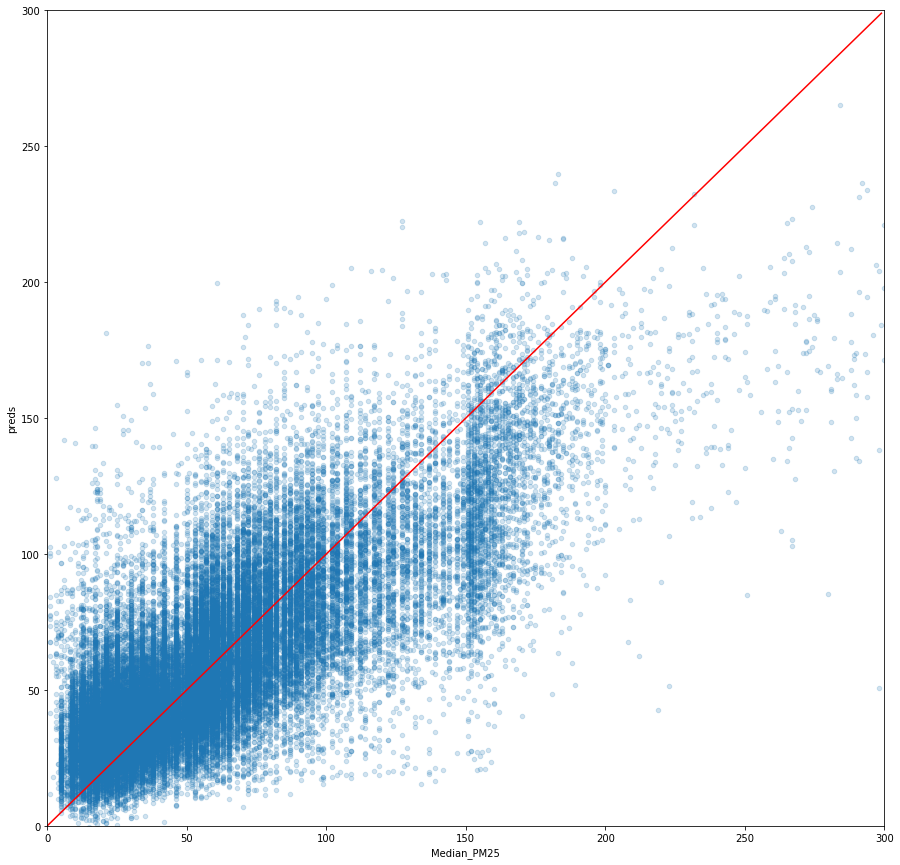

In [ ]:
for i, test_df in enumerate(test_dfs):
  test_df['preds'] = predictions[i]

ax = test_dfs[0].plot(x='Median_PM25', y='preds', kind='scatter', alpha=0.2, figsize=(15, 15), ylim=(0, 300), xlim=(0, 300))
ax.plot(range(300), range(300), color='red')
plt.savefig('pred_vs_actual.png')

In [ ]:
tdf = pd.concat(test_dfs)
print(tdf.shape)

(52852, 169)


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

In [ ]:
r2_score(tdf['Median_PM25'], tdf['preds'])

0.6153138409578824

In [ ]:
mean_absolute_error(tdf['Median_PM25'], tdf['preds'])

19.200244518421652

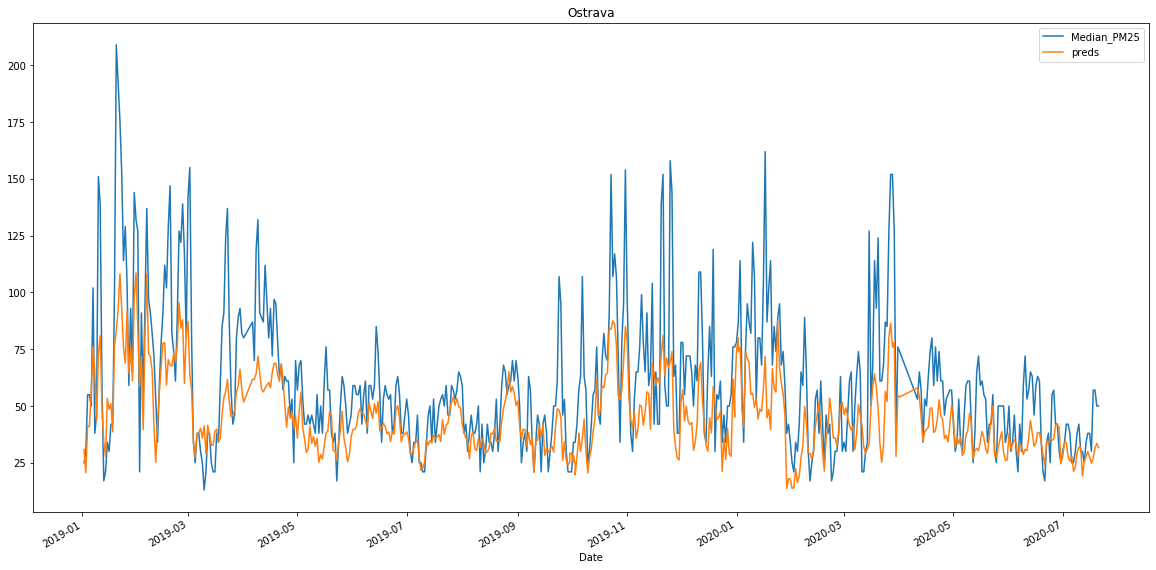

In [ ]:
# Plot timeseries for a city
city = tdf.City.sample().values[0]
ax = tdf.loc[tdf.City == city].plot(y='Median_PM25', x='Date', figsize=(20, 10), title=city)
tdf.loc[tdf.City == city].plot(y='preds', ax=ax, x='Date')

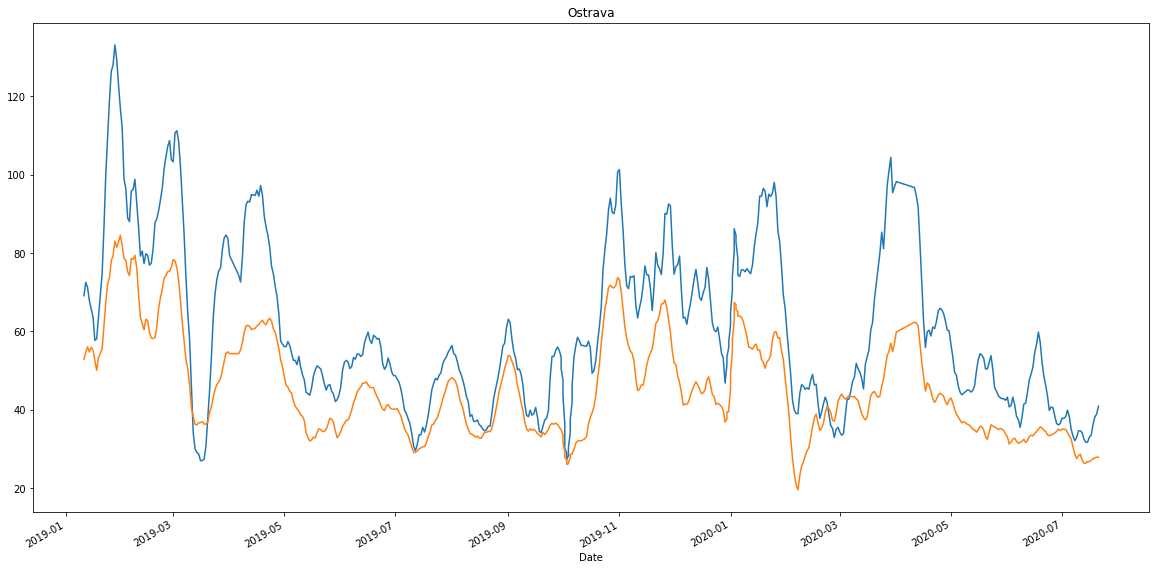

In [ ]:
# Plot a smoothed version
t = tdf.loc[tdf.City == city].copy()
t = t.set_index('Date')
ax = t.rolling(10).mean()['Median_PM25'].plot(figsize=(20, 10), title=city)
t.rolling(10).mean()['preds'].plot(ax=ax)

### Looking at accuracy in terms of how often it get's the right air quality class

In [ ]:
def pred_to_class(v):
    if v < 50:
        return 0
    elif v < 100:
        return 1
    elif v < 150:
        return 2
    elif v < 200:
        return 3
    elif v < 300:
        return 4
    else:
        return 5
tdf['true_class'] = tdf['Median_PM25'].map(pred_to_class)
tdf['pred_class'] = tdf['preds'].map(pred_to_class)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
accuracy_score(tdf['true_class'], tdf['pred_class'])

0.6672027548626352

In [ ]:
confusion_matrix(tdf['true_class'], tdf['pred_class'])

array([[21024,  5228,   195,    10,     0,     0],
       [ 5318, 11919,  1884,    92,     0,     0],
       [  166,  2081,  1669,   159,    10,     0],
       [   28,   561,  1471,   624,    37,     0],
       [    1,     9,    78,   185,    27,     0],
       [    0,     0,     3,    35,    38,     0]])

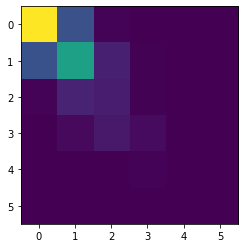

In [ ]:
plt.imshow(confusion_matrix(tdf['true_class'], tdf['pred_class']))

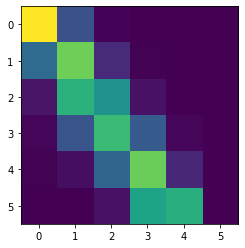

In [ ]:
plt.imshow(confusion_matrix(tdf['true_class'], tdf['pred_class'], normalize='true'))

In [ ]:
# How often is it correct within one class?
tdf['correct_1'] = (tdf['true_class'] == tdf['pred_class']).astype(int)
tdf['correct_1'] += (tdf['true_class'] == tdf['pred_class']-1).astype(int)
tdf['correct_1'] += (tdf['true_class'] == tdf['pred_class']+1).astype(int)
tdf['correct_1'].sum()/len(tdf)

0.9775221372890335